## 安装教程

我们推荐使用Anaconda来管理Python当中用到的各种工具包。首先我们在官网 https://www.anaconda.com/products/individual 里根据当前使用的计算机系统选择对应的版本下载。下载完毕后需要将存储Anaconda的路径加入到全局变量中

使用如下命令创建一个新的虚拟环境，名为torch，使用python 3.8

`conda create --name gnn python=3.8 -y`

接着启动该虚拟环境

`conda activate gnn`

然后我们安装必要的工具包

`pip install torch torchvision`

`pip install matplotlib`

接下来我们需要将`gnn`这个虚拟环境加入到jupyter notebook的kernel中

`conda install -c anaconda ipykernel`

`python -m ipykernel install --user --name=gnn`

启动jupyter notebook

`jupyter notebook`

我们可以看到一个kernel是`gnn`，意味着我们可以使用`gnn`这个虚拟环境的工具包了

![](figures/jupkernel.png)

# 第二讲： 深度学习基础

Jupyter Notebook的安装
请参考https://www.jianshu.com/p/91365f343585 第二部分（安装Jupyter Notebook）

In [1]:
# 在开始之前需要确保我们安装了如下工具包
# pytorch, torchvision, matplotlib
# 导入必要的工具包
import torch
from torch import nn
import torch.nn.functional as F

## 0. PyTorch基础
PyTorch是当下非常火热的深度学习框架，其简洁的接口设计和详细的文档极大了降低了学习成本。不同于另一个热门深度学习框架TensorFlow, PyTorch基于动态图，也就是说，PyTorch每次前向计算的时候都会重新构建一个新的计算图。这个特性使得PyTorch更加直观，写代码的逻辑更加接近Python本身的风格，也更加便于debug。接下来我们介绍PyTorch的一些重要特性。

### 0.1 Tensor对象
PyTorch的核心是Tensor对象。Tensor是多维数组对象，可用于表示一维向量和高维矩阵。PyTorch提供了用于数组快速操作的各种API，并且用户可以使用GPU来加速涉及到Tensor的计算。Tensor对象和Numpy的ndarray对象非常相似，都是表示多维数组，而且许多API也类似。

In [2]:
# 创建一个2x3的random tensor（可用于模型参数初始化）
a = torch.randn((2, 3))
print(a)

tensor([[-1.0680, -0.5468, -0.2516],
        [ 1.1025, -0.3364, -0.1936]])


In [3]:
b = torch.ones((2, 3))
print(b)
print(a + b)

tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[-0.0680,  0.4532,  0.7484],
        [ 2.1025,  0.6636,  0.8064]])


In [4]:
a.add(b)

tensor([[-0.0680,  0.4532,  0.7484],
        [ 2.1025,  0.6636,  0.8064]])

In [5]:
c = torch.ones((3, 2))
print(c)
print(a.mm(c))  # mm是matmul的意思，表示矩阵相乘，这里的到一个2x2的矩阵

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])
tensor([[-1.8664, -1.8664],
        [ 0.5725,  0.5725]])


In [6]:
# a.to('cpu') # 将该tensor放在cpu上；也可以不写这行代码，tensor默认放在cpu上的
a.to('cuda') # 将该tensor放在gpu上；如果没有配置好cuda的话会报错

tensor([[-1.0680, -0.5468, -0.2516],
        [ 1.1025, -0.3364, -0.1936]], device='cuda:0')

### 0.2 PyTorch中的反向传播
PyTorch的另一大特性就是可以对计算过程进行自动求导，便于反向转播。对tensor的每一个操作都会留下计算图，并保留求导的路径。

### 0.2.1 Autograd自动求导

In [7]:
# 首先我们创建一个能够计算梯度的tensor，记为a_（和前面的a区别开）
a_ = torch.ones((2,2), requires_grad=True)
a_

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

In [8]:
# 因为没有对a_进行任何操作，所以a_.grad是None
a_.grad

In [9]:
b_ = a_ + 1
b_

tensor([[2., 2.],
        [2., 2.]], grad_fn=<AddBackward0>)

我们可以看到b这个tensor里有一个grad_fn,这个grad_fn记录了创建b这个tensor的操作，这样便于之后反向传播（求导）

In [10]:
# 定义一个变量sum_
sum_ = b_.sum()
sum_

tensor(8., grad_fn=<SumBackward0>)

In [11]:
# 然后我们反向传播
sum_.backward()

In [12]:
# 接着我们就能直接得到a_的梯度了
a_.grad

tensor([[1., 1.],
        [1., 1.]])

值得注意的是，`backward()`函数调用一次之后会把涉及到的计算图清零，如果连续调用两次`backward()`，第二次`backward()就会报错

### 0.2.2 PyTorch中的optimizer
在0.2.1中我知道了可以通过`backward()`函数求得tensor的梯度，那么直接使用梯度下降就可以更新参数了。梯度下降有很多变种，比如SGD、Momentum梯度下降、Adam梯度下降，PyTorch已经在`torch.optim`中为我们实现好了这些优化方法，我们可以直接使用。

In [13]:
param = nn.Parameter(torch.ones(2,2))
optimizer0 = torch.optim.SGD([param], lr=0.1)

In [14]:
# 我们自行定义一个损失函数，它是param里每个元素的平方和，所以当loss最小时（即0），param里的值全是0
loss0 = (param**2).sum()

In [15]:
# 每次backward前我们需要调用zero_grad()来清空参数里的梯度，不然的话这个grad值会一直累积
optimizer0.zero_grad() 
loss0.backward()
optimizer0.step()
print(param)

Parameter containing:
tensor([[0.8000, 0.8000],
        [0.8000, 0.8000]], requires_grad=True)


In [16]:
# 我们也可以写一个循环来优化参数，如下
for i in range(20):
    optimizer0.zero_grad()
    loss0 = (param**2).sum()
    loss0.backward()
    optimizer0.step()
    print('loss value: {:.2f}'.format(loss0.item()))
print('优化后的参数：', param)

loss value: 2.56
loss value: 1.64
loss value: 1.05
loss value: 0.67
loss value: 0.43
loss value: 0.27
loss value: 0.18
loss value: 0.11
loss value: 0.07
loss value: 0.05
loss value: 0.03
loss value: 0.02
loss value: 0.01
loss value: 0.01
loss value: 0.00
loss value: 0.00
loss value: 0.00
loss value: 0.00
loss value: 0.00
loss value: 0.00
优化后的参数： Parameter containing:
tensor([[0.0092, 0.0092],
        [0.0092, 0.0092]], requires_grad=True)


从上面的例子我们可以看到，`loss`值在不断减小，而最后我们得到的`param`也非常接近于0。

## 1. 加载数据

我们以MNIST数据集为例展示PyTorch中如何加载数据。MNIST数据集包含了10种不同手写的数字，即0到9。每张图片的标签也就是0到9中的某个数字。在这个数据集上，我们的任务是预测图片对应哪个数字，所以这是一个分类问题。

`torchvision`中收集了多种数据集，我们可以直接调用这个工具包来下载我们需要的数据。

In [17]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# 下载MNIST数据集中的训练集，并保存到data文件夹
data_train = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
# 加载MNIST数据集中的测试集
data_test = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

这里可能会有个warning，不过我们不需要管它。

`data_train`和`data_test`是`dataset.MNIST`的对象，我们可以按下标访问其中的内容，会得到形如`(data, label)`的数据。

In [18]:
img, label = data_train[0] # 取出第一个数据（第一张图片）
img.size() 

torch.Size([1, 28, 28])

我们不难发现每张图其实是一个三维的矩阵。注意，MNIST数据是单通道图片，所以`(1, 28, 28)`的第一维度是1。

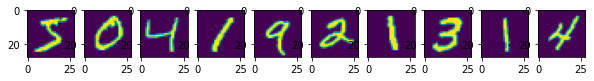

In [19]:
# 可视化前10个数据
plt.figure(figsize=(10, 2))
for i in range(10):
    img, label = data_train[i]
    img = img.numpy().squeeze() # 用squeeze()函数将img的size从（1，28，28）变成（28，28），从而方便可视化
    plt.subplot(1, 10, i+1)
    plt.imshow(img)

## 2. 前馈神经网络

在前面的部分中，我们了解了在PyTorch如何加载数据。接下来我们讲解如何在PyTorch中搭建、训练前馈神经网络，并完成分类任务。

### 2.1. 搭建神经网络

首先我们回顾一下前馈神经网络的构造。下图展示了有两层网络层的神经网络，即（1）输入到隐藏层和（2）隐藏层到输出。输出的向量我们通常会再经过一层Softmax得到每个类别的概率，然后计算损失函数。接下来我们展示在PyTorch搭建网络的方法。注意，前馈神经网络也称多层感知机（Multi-Layer Perceptron, MLP），在后面的描述中我们会使用MLP来代表前馈神经网络。
![](figures/2-layer-mlp.png)

### 2.1.1 用矩阵运算搭建神经网络层

因为神经网络里的运算其实就是在对矩阵进行操作，所以我们可以直接把网络用矩阵运算来表示。例如，给定输入`x`，一个线性层里的操作可以表示为: `x' = W x + b`，其中W和b是这个线性层的参数。遵循面向对象编程（Object Oriented Programming，OOP）的原则，我们定义一个前馈神经网络的类，把我们需要的功能封装在其中。我们可以按照如下的逻辑来设计一个两层前馈神经网络：
```
# 伪代码
class MLP:
    def __init__(self):
        self.layer1 = xxx
        self.layer2 = xxx
    
    def forward(self, x): # x是模型输入
        # 执行self.layer1的功能
        # 非线性激活函数
        # 执行self.layer2的功能
        return something
```
上面的代码不是一股脑地把网络直接实现，而是将网络的每一层解耦，这样可以便于我们拓展这个网络的功能（增加更多网络层或者改变网络层内部实现），并且避免这个类变得过于臃肿。接下来我们展示在PyTorch中怎么具体设计这个网络层（定义一个线性类，名为Linear）。

In [20]:
class Linear(nn.Module): # 继承torch.nn.Module
    def __init__(self, in_features, out_features):
        super(Linear, self).__init__() # super()是表示调用父类的函数，这行代码相当于nn.Module.__init__(self)
        self.weight = nn.Parameter(torch.randn(in_features, out_features)) 
        self.bias = nn.Parameter(torch.randn(out_features))
    
    def forward(self, x): # x是模型输入
        x = x.mm(self.weight) 
        return x + self.bias

一些注意事项：
1. 定义的`Linear`层需要继承`nn.Module`(`torch.nn.Module`)这个类。继承这个类之后，`Linear`这个类就能使用`nn.Module`类里定义好的函数。比如`eval()`、`to()`。 同时继承之后需要调用父类的初始化函数，即`super(Linear, self).__init__()`；
1. 这里我们定义了两种参数，即`self.weight`和`self.bias`；
1. 我们在定义parameter的时候，使用了`torch.randn()`，相当于对参数进行了初始化；
1. `forward`函数表示网络里的前向过程，得到输出。由于该类继承了nn.Module，当我们实例化该类后，如`layer = Linear(...)`，`layer()`就等于`layer.forward()`；
1. 注意这里我们没有使用Softmax层，因为后面我们使用损失函数是`torch.nn.CrossEntropyLoss`，它里面已经包含了Softmax操作。

In [21]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(MLP, self).__init__()
        self.in_features = in_features
        self.layer1 = Linear(in_features, hidden_features)  # 此处的Linear()是我们前面自定义的Linear类
        self.layer2 = Linear(hidden_features, out_features)
        
    def forward(self,x):
        x = x.view(-1, self.in_features) # 将每张图片转换成向量
        x = self.layer1(x)
        x = F.relu(x) # 非线性激活层，ReLU函数
        return self.layer2(x)

**一些注意事项**：
1. 同样的，`MLP`这个类也需要继承`nn.Module`；
2. 层与层之间我们需要一个非线性激活层，这里我们使用ReLU;
3. 不是所有的MLP都需要这一步`x = x.view(-1, self.in_features)`，这里只是因为我们的输入数据是二维图片，我们需要将其变为向量。

### 2.1.2 用PyTorch里预定义的神经网络层
接下来我们将直接使用PyTorch里定义好的线性层（`torch.nn.Linear`）而非手动定义。

In [22]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(MLP, self).__init__()
        self.in_features = in_features
        self.layer1 = nn.Linear(in_features, hidden_features) # 此处的nn.Linear是PyTorch里定义的线性层
        self.layer2 = nn.Linear(hidden_features, out_features)
        
    def forward(self, x):
        x = x.view(-1, self.in_features) # 将每张图片转换成向量
        x = self.layer1(x)
        x = F.relu(x) # 非线性激活层，ReLU函数
        return self.layer2(x)

这个MLP同前面我们的手动定义的MLP的不同之处就在于，`self.layer1`和`self.layer2`是直接调用的PyTorch中定义好的`nn.Linear`。`torch.nn`中还定义了许多网络层，如卷积层、池化层等等。详情可见[该链接](https://pytorch-cn.readthedocs.io/zh/latest/package_references/torch-nn/#_1)。

### 2.1.3 神经网络的前向过程 Foward propogation

In [23]:
# 这里我们继续以第一张图片为例来演示神经网络的前向过程
# 我们首先实例化一个MLP，
img, label = data_train[0]
img = img.view(-1)  # view(-1)表示把矩阵变成一维向量: (1,28,28) --> (784,)
feat_dim = len(img) # 计算输入的特征的维度（图片的维度）
num_classes = 10
model = MLP(in_features=feat_dim, hidden_features=256, out_features=num_classes)

In [24]:
model

MLP(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=10, bias=True)
)

In [25]:
# 我们定义一个device变量，用于决定我们是否要把数据和模型放在GPU上运行
# 如果没有安装cuda的话，则使用cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
device

'cuda'

In [27]:
# 将模型和数据放在device上（放在cpu或者gpu上）
model = model.to(device) 
img = img.to(device)  

In [28]:
output = model(img)
output

tensor([[ 0.0387, -0.0440, -0.1172,  0.0814, -0.0507, -0.1659,  0.0801,  0.0254,
         -0.0079, -0.0690]], device='cuda:0', grad_fn=<AddmmBackward>)

模型的输出是一个长度为10的向量，我们可以认为每个元素代表对应类别的概率（这里是未归一化的概率，通常称为logits）

In [29]:
# 我们取出其中最大值对应的类别，并和真实类别就行比较
predicted = output.argmax()
print('预测标签:', predicted.item(), '; 实际标签:', label)

预测标签: 3 ; 实际标签: 5


### 2.2 训练神经网络
前面我们讲述了怎么搭建一个神经网络以及如何得到对应数据的输出，但是模型里的参数并没有优化过，所以预测效果往往很差。接下来我们讲解如何训练一个神经网络。
```
# 伪代码
def train():
    for epoch in num_epochs:
        # 取一个batch的数据
        # 前向传播forward
        # 计算损失函数
        # 反向传播backward
        # 更新参数
```

In [30]:
# 我们定义一个train函数来封装我们的训练过程
def train(model, data, num_epochs=5, learning_rate=1e-3, batch_size=32):
    # 定义一个优化器，Adam优化器是梯度下降法的一个变种
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # weight_decay表示L2正则项
    
    # 把训练数据封装到DataLoader，这样便于我们以及选取batch以及打乱数据顺序
    train_loader = torch.utils.data.DataLoader(data, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        loss_total = 0 # 定义一个loss_total变量来记录我们的loss变化
        for data in train_loader:
            # 梯度清零
            optimizer.zero_grad()
            
            img, label = data
            img = img.to(device)
            label = label.to(device)
            
            # 前向传播和反向传播 
            output = model(img)
            loss = criterion(output, label)
            loss.backward()
            
            # 优化参数
            optimizer.step()
            
        loss_total += loss.item() 
        print('Epoch: {}, Training Loss: {:.4f}'.format(epoch+1, loss_total))


In [31]:
train(model, data_train)

Epoch: 1, Training Loss: 0.0634
Epoch: 2, Training Loss: 0.0846
Epoch: 3, Training Loss: 0.0767
Epoch: 4, Training Loss: 0.0186
Epoch: 5, Training Loss: 0.0851


In [32]:
@torch.no_grad() # 由于测试的时候不需要求导，可以暂时关闭autograd，提高速度，节约内存
def test(model, data, batch_size=128):
    num_correct = 0 # 预测正确的图片数
    num_total = 0 # 总共的图片数
    
    test_loader = torch.utils.data.DataLoader(data, 
                                              batch_size=batch_size, 
                                              shuffle=False)
    for data in test_loader: # 按batch取出测试集中的数据
        img, label = data
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        predicted = output.argmax(1)
        num_total += len(label)
        num_correct += (predicted == label).sum()

    print('共有{}张图片，准确率为: {:.2f}%'.format(num_correct, 100 * num_correct / num_total))    

In [33]:
test(model, data_train)
test(model, data_test)

共有59292张图片，准确率为: 98.82%
共有9746张图片，准确率为: 97.46%


## 3. 卷积神经网络 (CNN)


首先我们回归一下卷积神经网络CNN的结构图，![](figures/cnn.png)

它可以被拆分为两个块（block）：特征提取部分（feature extractor）和分类部分（classification）。特征提取部分由多个卷积层构成，而分类部分由全连接层，即前馈神经网络。因此我们在定义CNN的时候也可以按照这么两部分来定义。

In [34]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential( 
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64, 120),
            nn.ReLU(),
            nn.Linear(120, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 64) # 铺平成向量，flattening 
        x = self.classifier(x)
        return x

**注意**：
1. 这里我们不再手动定义卷积层了，直接调用`nn.Conv2d`。对于`nn.Conv2d(1, 16, 3, stride=2, padding=1)`，其中`1`表示输入有1个通道（channel），`16`表示该层的输出有`16`个通道，`stride=2`表示卷积的平移步长是2，`padding=1`表示填充的幅度。

2. 我们在定`self.features`的时候用到了`nn.Sequential()`，它是一个将多个网络层（和激活函数）结合起来的容器。用户可以通过`nn.Sequential()`来组合自己想搭建的神经网络。

In [35]:
model = CNN().to(device)

In [36]:
train(model, data_train) # 调用之前定义好的train函数

Epoch: 1, Training Loss: 0.0270
Epoch: 2, Training Loss: 0.0568
Epoch: 3, Training Loss: 0.0226
Epoch: 4, Training Loss: 0.0695
Epoch: 5, Training Loss: 0.0077


In [37]:
test(model, data_train)
test(model, data_test)

共有59399张图片，准确率为: 99.00%
共有9823张图片，准确率为: 98.23%


## 4. 自编码器 AutoEncoder
![](figures/autoencoder.png)
自编码器可以看作是一个试图从输出中重建输入的神经网络。它包含两个部分：编码器和解码器。编码器负责对输入进行编码，而解码器负责对编码后的信息进行重建。因此，作为一个示例，我们构建如下的由卷积神经网络构成的自编码器。

In [38]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # 我们用前面CNN中使用的特征提取部分当作这里的编码器encoder
        self.encoder = nn.Sequential( 
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 7)
        )
        
        # 对于解码器decoder，我们需要使用nn.ConvTranspose2d
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

其中编码器由卷积层构成，解码器都由反卷积层构成。

In [39]:
autoencoder = Autoencoder().to(device) # device is either 'cpu' or 'cuda'

In [40]:
# 大体上跟前面train()函数一致，只是损失函数和输入有所不同
def train_autoencoder(model, data, num_epochs=10, learning_rate=1e-3, batch_size=32):
    # 定义一个优化器，Adam优化器是梯度下降法的一个变种
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # weight_decay表示L2正则项
    
    # 把训练数据封装到DataLoader，这样便于我们以及选取batch以及打乱数据顺序
    train_loader = torch.utils.data.DataLoader(data, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    # 定义损失函数，这里我们使用MSE loss来衡量输出和输入的差别
    criterion = nn.MSELoss()
    
    for epoch in range(num_epochs):
        loss_total = 0 # 定义一个loss_total变量来记录我们的loss变化
        for data in train_loader:
            # 梯度清零
            optimizer.zero_grad()
            
            img, _ = data
            img = img.to(device)
            
            # 前向传播和反向传播 
            output = model(img)
            loss = criterion(output, img)
            loss.backward()
            
            # 优化参数
            optimizer.step()
            
        loss_total += loss.item() 
        print('Epoch: {}, Training Loss: {:.4f}'.format(epoch+1, loss_total))


In [41]:
train_autoencoder(autoencoder, data_train)

Epoch: 1, Training Loss: 0.0096
Epoch: 2, Training Loss: 0.0059
Epoch: 3, Training Loss: 0.0063
Epoch: 4, Training Loss: 0.0053
Epoch: 5, Training Loss: 0.0056
Epoch: 6, Training Loss: 0.0053
Epoch: 7, Training Loss: 0.0049
Epoch: 8, Training Loss: 0.0057
Epoch: 9, Training Loss: 0.0042
Epoch: 10, Training Loss: 0.0051


In [42]:
# 观察生成的图片的质量
test_loader = torch.utils.data.DataLoader(data_test, 
                                          batch_size=8, 
                                          shuffle=False)


for i, data in enumerate(test_loader):
    img, _ = data
    img_new = autoencoder(img).detach().numpy()
    img = img.numpy()
    plt.figure(figsize=(8, 2))
    for j in range(8):
        plt.subplot(2, 8, j+1)
        plt.imshow(img_new[j].squeeze())
        plt.subplot(2, 8, 8+j+1)
        plt.imshow(img[j].squeeze())
    if i >= 2:
        break

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

参考资料：

[1] https://pytorch-cn.readthedocs.io/zh/latest/#pytorch

[2] https://www.cs.toronto.edu/~lczhang/360/lec/w05/autoencoder.htmlv